In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from keras.models import Sequential, Input, Model
from keras.layers import LSTM, Bidirectional, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tcn import TCN
from nbeats_keras.model import NBeatsNet
#from attention_decoder import AttentionDecoder

Using TensorFlow backend.


In [2]:
data = pd.read_csv('data/EURGBP.csv')

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-01-01,0.6547,0.6547,0.6497,0.6504,0.6504,0.0
1,2003-01-02,0.6503,0.6627,0.6475,0.6494,0.6494,0.0
2,2003-01-03,0.6496,0.6516,0.6466,0.6472,0.6472,0.0
3,2003-01-06,0.6471,0.6523,0.6467,0.6502,0.6502,0.0
4,2003-01-07,0.6498,0.6510,0.6477,0.6490,0.6490,0.0


In [4]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4430,2019-12-25,0.85700,0.86070,0.84913,0.85700,0.85700,0.0
4431,2019-12-26,0.85520,0.85550,0.85290,0.85530,0.85530,0.0
4432,2019-12-27,0.85370,0.85632,0.85095,0.85380,0.85380,0.0
4433,2019-12-30,0.85406,0.85558,0.85128,0.85406,0.85406,0.0
4434,2019-12-31,0.85419,0.85480,0.84544,0.85426,0.85426,0.0


In [5]:
data = data.dropna()
data.isnull().values.any()

False

In [6]:
test_frac = 0.1
split = len(data) - round(test_frac*len(data))
#split
df_train = data[:split]
df_test = data[split:]

In [7]:
print(len(df_train))
print(len(df_test))

3965
441


In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#sc = MinMaxScaler()
sc = StandardScaler()
df_train_scale = sc.fit_transform(df_train['Close'].values.reshape(-1,1))
df_test_scale = sc.transform(df_test['Close'].values.reshape(-1,1))

In [9]:
df_train_scale

array([[-1.61547514],
       [-1.6276607 ],
       [-1.65446891],
       ...,
       [ 1.09641972],
       [ 1.09958796],
       [ 1.09934425]])

In [10]:
input_time_step = 16
output_time_step = [2,3,5,7,10]
epoch = 1000
batch_size = 32
validation_split=0.1
optimizer = 'adam'
loss = 'mean_squared_error'
dropout = 0.1
units = 100
dilations=[1, 2, 4, 8]
callback = EarlyStopping(monitor = 'val_loss', 
                         min_delta = 1e-4, 
                         patience = 100, 
                         verbose=1, 
                         mode='auto', 
                         restore_best_weights=True)
RMSE = []
MAE = []

In [11]:
for step in output_time_step:
    
    # Creating supervised dataset
    in_start = 0
    x_train = []
    y_train = []
    for i in range(len(df_train_scale)):
        in_end = in_start + input_time_step
        out_end = in_end + step
        if out_end < len(df_train_scale):
            x_train.append(df_train_scale[in_start:in_end, 0])
            y_train.append(df_train_scale[in_end:out_end, 0])
        in_start += 1
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    print(x_train.shape)
    print(y_train.shape)
    
    # TCN Model
    i = Input(shape=(x_train.shape[1], x_train.shape[2]))
    m = TCN(nb_filters=units, dilations=dilations, dropout_rate=dropout)(i)
    m = Dense(step, activation='linear')(m)
    model = Model(inputs=[i], outputs=[m])

    model.compile(optimizer = optimizer, loss = loss)
    
    # Training Model
    history = model.fit(x_train, 
                        y_train,
                        validation_split = validation_split,
                        callbacks = [callback], 
                        epochs = epoch, 
                        batch_size = batch_size, 
                        shuffle = False)
    
    
    # Prediction on Test Set
    pred_vector = np.empty((0, step))
    real_vector = np.empty((0, step))

    for i in range(df_test_scale.size):

        if(i+step+input_time_step < df_test_scale.size): 
            val = df_test_scale[i:i+input_time_step]
            #print(i, i+input_time_step)
            val = val.reshape((1, len(val), 1))
            #print(val.shape)
            pred = model.predict(val)
            pred = sc.inverse_transform(pred)
            pred_vector = np.append(pred_vector,pred,axis=0)
            real = df_test_scale[i+input_time_step:i+input_time_step+step].reshape(1,step)
            #print(i+input_time_step,i+input_time_step+output_time_step)
            real = sc.inverse_transform(real)
            real_vector = np.append(real_vector,real,axis=0)
        else:
            break
    
    print(pred_vector.shape)
    print(real_vector.shape)
    
    # Calculate Accuracy
    sum_mae = 0
    sum_rmse = 0
    for i in range(len(pred_vector)):#same as real_vector
        mae = metrics.mean_absolute_error(real_vector[i], pred_vector[i])
        mse = metrics.mean_squared_error(real_vector[i], pred_vector[i])
        rmse = np.sqrt(mse)
        sum_mae = sum_mae + mae
        sum_rmse = sum_rmse + rmse

    # Average MAE
    avg_mae = sum_mae / len(pred_vector)
    # Average RMSE
    avg_rmse = sum_rmse / len(pred_vector)
    
    RMSE.append(avg_rmse)
    MAE.append(avg_mae)

(3947, 16, 1)
(3947, 2)
Train on 3552 samples, validate on 395 samples
Epoch 1/1000
3552/3552 [==============================] - 7s 2ms/step - loss: 6.5020 - val_loss: 0.4690
Epoch 2/1000
3552/3552 [==============================] - 3s 789us/step - loss: 0.3768 - val_loss: 0.0109
Epoch 3/1000
3552/3552 [==============================] - 5s 1ms/step - loss: 0.1614 - val_loss: 0.0390
Epoch 4/1000
3552/3552 [==============================] - 6s 2ms/step - loss: 0.0965 - val_loss: 0.0079
Epoch 5/1000
3552/3552 [==============================] - 5s 1ms/step - loss: 0.0814 - val_loss: 0.0620
Epoch 6/1000
3552/3552 [==============================] - 3s 942us/step - loss: 0.0525 - val_loss: 0.0069
Epoch 7/1000
3552/3552 [==============================] - 6s 2ms/step - loss: 0.0438 - val_loss: 0.0209
Epoch 8/1000
3552/3552 [==============================] - 5s 1ms/step - loss: 0.0362 - val_loss: 0.0149
Epoch 9/1000
3552/3552 [==============================] - 4s 1ms/step - loss: 0.0308 - val_lo

Epoch 78/1000
3552/3552 [==============================] - 5s 1ms/step - loss: 0.0075 - val_loss: 0.0045
Epoch 79/1000
3552/3552 [==============================] - 5s 1ms/step - loss: 0.0073 - val_loss: 0.0045
Epoch 80/1000
3552/3552 [==============================] - 5s 1ms/step - loss: 0.0067 - val_loss: 0.0044
Epoch 81/1000
3552/3552 [==============================] - 5s 1ms/step - loss: 0.0065 - val_loss: 0.0044
Epoch 82/1000
3552/3552 [==============================] - 5s 1ms/step - loss: 0.0066 - val_loss: 0.0044
Epoch 83/1000
3552/3552 [==============================] - 5s 1ms/step - loss: 0.0067 - val_loss: 0.0053
Epoch 84/1000
3552/3552 [==============================] - 5s 1ms/step - loss: 0.0063 - val_loss: 0.0044
Epoch 85/1000
3552/3552 [==============================] - 5s 1ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 86/1000
3552/3552 [==============================] - 4s 1ms/step - loss: 0.0065 - val_loss: 0.0046
Epoch 87/1000
3552/3552 [==============================

3552/3552 [==============================] - 3s 960us/step - loss: 0.0049 - val_loss: 0.0076
Epoch 156/1000
3552/3552 [==============================] - 5s 1ms/step - loss: 0.0051 - val_loss: 0.0057
Epoch 157/1000
3552/3552 [==============================] - 5s 1ms/step - loss: 0.0064 - val_loss: 0.0105
Epoch 158/1000
3552/3552 [==============================] - 4s 1ms/step - loss: 0.0477 - val_loss: 0.0252
Epoch 159/1000
3552/3552 [==============================] - 3s 720us/step - loss: 0.0272 - val_loss: 0.0639
Epoch 160/1000
3552/3552 [==============================] - 5s 1ms/step - loss: 0.0104 - val_loss: 0.1005
Epoch 161/1000
3552/3552 [==============================] - 5s 1ms/step - loss: 0.0090 - val_loss: 0.0525
Epoch 162/1000
3552/3552 [==============================] - 5s 1ms/step - loss: 0.0082 - val_loss: 0.0444
Epoch 163/1000
3552/3552 [==============================] - 5s 1ms/step - loss: 0.0074 - val_loss: 0.0231
Epoch 164/1000
3552/3552 [==============================]

3551/3551 [==============================] - 5s 1ms/step - loss: 0.0093 - val_loss: 0.0595
Epoch 56/1000
3551/3551 [==============================] - 5s 1ms/step - loss: 0.0088 - val_loss: 0.0251
Epoch 57/1000
3551/3551 [==============================] - 5s 1ms/step - loss: 0.0100 - val_loss: 0.0454
Epoch 58/1000
3551/3551 [==============================] - 5s 1ms/step - loss: 0.0116 - val_loss: 0.0625
Epoch 59/1000
3551/3551 [==============================] - 4s 1ms/step - loss: 0.0105 - val_loss: 0.0785
Epoch 60/1000
3551/3551 [==============================] - 5s 1ms/step - loss: 0.0104 - val_loss: 0.0285
Epoch 61/1000
3551/3551 [==============================] - 4s 1ms/step - loss: 0.0100 - val_loss: 0.0523
Epoch 62/1000
3551/3551 [==============================] - 4s 1ms/step - loss: 0.0095 - val_loss: 0.0362
Epoch 63/1000
3551/3551 [==============================] - 4s 1ms/step - loss: 0.0094 - val_loss: 0.0298
Epoch 64/1000
3551/3551 [==============================] - 4s 1ms/ste

3551/3551 [==============================] - 5s 1ms/step - loss: 0.0069 - val_loss: 0.0087
Epoch 133/1000
3551/3551 [==============================] - 5s 1ms/step - loss: 0.0065 - val_loss: 0.0108
Epoch 134/1000
3551/3551 [==============================] - 5s 1ms/step - loss: 0.0067 - val_loss: 0.0122
Epoch 135/1000
3551/3551 [==============================] - 5s 1ms/step - loss: 0.0092 - val_loss: 0.0223
Epoch 136/1000
3551/3551 [==============================] - 5s 2ms/step - loss: 0.0296 - val_loss: 0.0184
Epoch 137/1000
3551/3551 [==============================] - 3s 717us/step - loss: 0.0119 - val_loss: 0.0253
Epoch 138/1000
3551/3551 [==============================] - 6s 2ms/step - loss: 0.0092 - val_loss: 0.0446
Epoch 139/1000
3551/3551 [==============================] - 4s 1ms/step - loss: 0.0100 - val_loss: 0.0186
Epoch 140/1000
3551/3551 [==============================] - 5s 1ms/step - loss: 0.0068 - val_loss: 0.0181
Epoch 141/1000
3551/3551 [==============================] -

3551/3551 [==============================] - 4s 1ms/step - loss: 0.0070 - val_loss: 0.0084
Epoch 210/1000
3551/3551 [==============================] - 4s 1ms/step - loss: 0.0065 - val_loss: 0.0062
Epoch 211/1000
3551/3551 [==============================] - 5s 1ms/step - loss: 0.0068 - val_loss: 0.0133
Epoch 212/1000
3551/3551 [==============================] - 4s 1ms/step - loss: 0.0066 - val_loss: 0.0102
Epoch 213/1000
3551/3551 [==============================] - 4s 1ms/step - loss: 0.0068 - val_loss: 0.0107
Epoch 214/1000
3551/3551 [==============================] - 5s 1ms/step - loss: 0.0069 - val_loss: 0.0078
Epoch 215/1000
3551/3551 [==============================] - 5s 1ms/step - loss: 0.0071 - val_loss: 0.0080
Epoch 216/1000
3551/3551 [==============================] - 5s 1ms/step - loss: 0.0070 - val_loss: 0.0095
Epoch 217/1000
3551/3551 [==============================] - 4s 1ms/step - loss: 0.0065 - val_loss: 0.0085
Epoch 218/1000
3551/3551 [==============================] - 5

3551/3551 [==============================] - 4s 1ms/step - loss: 0.0062 - val_loss: 0.0083
Epoch 287/1000
3551/3551 [==============================] - 3s 760us/step - loss: 0.0063 - val_loss: 0.0062
Epoch 288/1000
3551/3551 [==============================] - 4s 1ms/step - loss: 0.0062 - val_loss: 0.0072
Epoch 289/1000
3551/3551 [==============================] - 3s 796us/step - loss: 0.0064 - val_loss: 0.0128
Epoch 290/1000
3551/3551 [==============================] - 5s 1ms/step - loss: 0.0061 - val_loss: 0.0108
Epoch 291/1000
3551/3551 [==============================] - 5s 1ms/step - loss: 0.0064 - val_loss: 0.0066
Epoch 292/1000
3551/3551 [==============================] - 5s 1ms/step - loss: 0.0063 - val_loss: 0.0180
Epoch 293/1000
3551/3551 [==============================] - 4s 1ms/step - loss: 0.0063 - val_loss: 0.0137
Epoch 294/1000
3551/3551 [==============================] - 5s 1ms/step - loss: 0.0067 - val_loss: 0.0060
Epoch 295/1000
3551/3551 [==============================]

3551/3551 [==============================] - 5s 2ms/step - loss: 0.0058 - val_loss: 0.0062
Epoch 364/1000
3551/3551 [==============================] - 5s 2ms/step - loss: 0.0060 - val_loss: 0.0083
Epoch 365/1000
3551/3551 [==============================] - 4s 1ms/step - loss: 0.0057 - val_loss: 0.0084
Restoring model weights from the end of the best epoch.
Epoch 00365: early stopping
(422, 3)
(422, 3)
(3944, 16, 1)
(3944, 5)
Train on 3549 samples, validate on 395 samples
Epoch 1/1000
3549/3549 [==============================] - 4s 1ms/step - loss: 6.7220 - val_loss: 0.1682
Epoch 2/1000
3549/3549 [==============================] - 3s 784us/step - loss: 0.2670 - val_loss: 0.0565
Epoch 3/1000
3549/3549 [==============================] - 2s 702us/step - loss: 0.1225 - val_loss: 0.0411
Epoch 4/1000
3549/3549 [==============================] - 5s 1ms/step - loss: 0.0893 - val_loss: 0.0355
Epoch 5/1000
3549/3549 [==============================] - 5s 1ms/step - loss: 0.0607 - val_loss: 0.0191


3549/3549 [==============================] - 5s 1ms/step - loss: 0.0135 - val_loss: 0.0247
Epoch 75/1000
3549/3549 [==============================] - 6s 2ms/step - loss: 0.0123 - val_loss: 0.0186
Epoch 76/1000
3549/3549 [==============================] - 5s 2ms/step - loss: 0.0119 - val_loss: 0.0151
Epoch 77/1000
3549/3549 [==============================] - 5s 1ms/step - loss: 0.0128 - val_loss: 0.0140
Epoch 78/1000
3549/3549 [==============================] - 5s 1ms/step - loss: 0.0123 - val_loss: 0.0187
Epoch 79/1000
3549/3549 [==============================] - 5s 1ms/step - loss: 0.0121 - val_loss: 0.0250
Epoch 80/1000
3549/3549 [==============================] - 5s 1ms/step - loss: 0.0127 - val_loss: 0.0125
Epoch 81/1000
3549/3549 [==============================] - 5s 1ms/step - loss: 0.0121 - val_loss: 0.0236
Epoch 82/1000
3549/3549 [==============================] - 5s 1ms/step - loss: 0.0119 - val_loss: 0.0171
Epoch 83/1000
3549/3549 [==============================] - 3s 784us/s

3549/3549 [==============================] - 5s 1ms/step - loss: 0.0103 - val_loss: 0.0262
Epoch 152/1000
3549/3549 [==============================] - 4s 1ms/step - loss: 0.0094 - val_loss: 0.0150
Epoch 153/1000
3549/3549 [==============================] - 5s 1ms/step - loss: 0.0101 - val_loss: 0.0173
Epoch 154/1000
3549/3549 [==============================] - 5s 1ms/step - loss: 0.0098 - val_loss: 0.0115
Epoch 155/1000
3549/3549 [==============================] - 4s 1ms/step - loss: 0.0096 - val_loss: 0.0102
Epoch 156/1000
3549/3549 [==============================] - 5s 1ms/step - loss: 0.0099 - val_loss: 0.0098
Epoch 157/1000
3549/3549 [==============================] - 4s 1ms/step - loss: 0.0105 - val_loss: 0.0110
Epoch 158/1000
3549/3549 [==============================] - 4s 1ms/step - loss: 0.0113 - val_loss: 0.0202
Epoch 159/1000
3549/3549 [==============================] - 5s 1ms/step - loss: 0.0097 - val_loss: 0.0190
Epoch 160/1000
3549/3549 [==============================] - 5

Epoch 9/1000
3547/3547 [==============================] - 4s 1ms/step - loss: 0.0297 - val_loss: 0.0209
Epoch 10/1000
3547/3547 [==============================] - 3s 932us/step - loss: 0.0273 - val_loss: 0.0254
Epoch 11/1000
3547/3547 [==============================] - 4s 1ms/step - loss: 0.0248 - val_loss: 0.0251
Epoch 12/1000
3547/3547 [==============================] - 3s 837us/step - loss: 0.0234 - val_loss: 0.0223
Epoch 13/1000
3547/3547 [==============================] - 3s 952us/step - loss: 0.0228 - val_loss: 0.0159
Epoch 14/1000
3547/3547 [==============================] - 4s 1ms/step - loss: 0.0215 - val_loss: 0.0223
Epoch 15/1000
3547/3547 [==============================] - 5s 1ms/step - loss: 0.0215 - val_loss: 0.0226
Epoch 16/1000
3547/3547 [==============================] - 3s 944us/step - loss: 0.0209 - val_loss: 0.0152
Epoch 17/1000
3547/3547 [==============================] - 3s 914us/step - loss: 0.0200 - val_loss: 0.0183
Epoch 18/1000
3547/3547 [=====================

3547/3547 [==============================] - 5s 1ms/step - loss: 0.0134 - val_loss: 0.0146
Epoch 87/1000
3547/3547 [==============================] - 5s 1ms/step - loss: 0.0141 - val_loss: 0.0259
Epoch 88/1000
3547/3547 [==============================] - 5s 1ms/step - loss: 0.0131 - val_loss: 0.0274
Epoch 89/1000
3547/3547 [==============================] - 5s 1ms/step - loss: 0.0125 - val_loss: 0.0160
Epoch 90/1000
3547/3547 [==============================] - 4s 1ms/step - loss: 0.0132 - val_loss: 0.0335
Epoch 91/1000
3547/3547 [==============================] - 4s 1ms/step - loss: 0.0131 - val_loss: 0.0244
Epoch 92/1000
3547/3547 [==============================] - 5s 1ms/step - loss: 0.0143 - val_loss: 0.0265
Epoch 93/1000
3547/3547 [==============================] - 5s 1ms/step - loss: 0.0168 - val_loss: 0.0831
Epoch 94/1000
3547/3547 [==============================] - 5s 1ms/step - loss: 0.0155 - val_loss: 0.0398
Epoch 95/1000
3547/3547 [==============================] - 2s 682us/s

3547/3547 [==============================] - 2s 564us/step - loss: 0.0132 - val_loss: 0.0176
Epoch 163/1000
3547/3547 [==============================] - 2s 575us/step - loss: 0.0122 - val_loss: 0.0124
Epoch 164/1000
3547/3547 [==============================] - 2s 542us/step - loss: 0.0130 - val_loss: 0.0201
Epoch 165/1000
3547/3547 [==============================] - 2s 565us/step - loss: 0.0126 - val_loss: 0.0136
Epoch 166/1000
3547/3547 [==============================] - 2s 564us/step - loss: 0.0124 - val_loss: 0.0126
Epoch 167/1000
3547/3547 [==============================] - 2s 558us/step - loss: 0.0122 - val_loss: 0.0121
Epoch 168/1000
3547/3547 [==============================] - 2s 535us/step - loss: 0.0131 - val_loss: 0.0127
Epoch 169/1000
3547/3547 [==============================] - 2s 562us/step - loss: 0.0129 - val_loss: 0.0252
Epoch 170/1000
3547/3547 [==============================] - 2s 538us/step - loss: 0.0129 - val_loss: 0.0131
Epoch 171/1000
3547/3547 [=================

Epoch 238/1000
3547/3547 [==============================] - 2s 605us/step - loss: 0.0118 - val_loss: 0.0126
Epoch 239/1000
3547/3547 [==============================] - 2s 565us/step - loss: 0.0115 - val_loss: 0.0119
Epoch 240/1000
3547/3547 [==============================] - 2s 566us/step - loss: 0.0113 - val_loss: 0.0131
Epoch 241/1000
3547/3547 [==============================] - 2s 582us/step - loss: 0.0120 - val_loss: 0.0122
Epoch 242/1000
3547/3547 [==============================] - 2s 560us/step - loss: 0.0118 - val_loss: 0.0128
Epoch 243/1000
3547/3547 [==============================] - 2s 563us/step - loss: 0.0122 - val_loss: 0.0163
Epoch 244/1000
3547/3547 [==============================] - 2s 562us/step - loss: 0.0117 - val_loss: 0.0133
Epoch 245/1000
3547/3547 [==============================] - 2s 568us/step - loss: 0.0120 - val_loss: 0.0183
Epoch 246/1000
3547/3547 [==============================] - 2s 559us/step - loss: 0.0124 - val_loss: 0.0128
Epoch 247/1000
3547/3547 [==

Epoch 66/1000
3545/3545 [==============================] - 3s 734us/step - loss: 0.0219 - val_loss: 0.0279
Epoch 67/1000
3545/3545 [==============================] - 3s 743us/step - loss: 0.0221 - val_loss: 0.0488
Epoch 68/1000
3545/3545 [==============================] - 3s 733us/step - loss: 0.0221 - val_loss: 0.0383
Epoch 69/1000
3545/3545 [==============================] - 3s 738us/step - loss: 0.0216 - val_loss: 0.0328
Epoch 70/1000
3545/3545 [==============================] - 3s 732us/step - loss: 0.0202 - val_loss: 0.0237
Epoch 71/1000
3545/3545 [==============================] - 3s 736us/step - loss: 0.0215 - val_loss: 0.0165
Epoch 72/1000
3545/3545 [==============================] - 3s 738us/step - loss: 0.0223 - val_loss: 0.0471
Epoch 73/1000
3545/3545 [==============================] - 3s 735us/step - loss: 0.0220 - val_loss: 0.0386
Epoch 74/1000
3545/3545 [==============================] - 3s 736us/step - loss: 0.0201 - val_loss: 0.0234
Epoch 75/1000
3545/3545 [============

3545/3545 [==============================] - 3s 973us/step - loss: 0.0175 - val_loss: 0.0179
Epoch 143/1000
3545/3545 [==============================] - 3s 797us/step - loss: 0.0167 - val_loss: 0.0233
Epoch 144/1000
3545/3545 [==============================] - 3s 731us/step - loss: 0.0163 - val_loss: 0.0226
Epoch 145/1000
3545/3545 [==============================] - 3s 725us/step - loss: 0.0170 - val_loss: 0.0208
Epoch 146/1000
3545/3545 [==============================] - 3s 739us/step - loss: 0.0169 - val_loss: 0.0209
Epoch 147/1000
3545/3545 [==============================] - 3s 706us/step - loss: 0.0168 - val_loss: 0.0235
Epoch 148/1000
3545/3545 [==============================] - 3s 705us/step - loss: 0.0170 - val_loss: 0.0177
Epoch 149/1000
3545/3545 [==============================] - 3s 720us/step - loss: 0.0173 - val_loss: 0.0169
Epoch 150/1000
3545/3545 [==============================] - 3s 724us/step - loss: 0.0178 - val_loss: 0.0184
Epoch 151/1000
3545/3545 [=================

In [12]:
RMSE

[0.0037925387647696034,
 0.004459273720139456,
 0.005376743832355205,
 0.00620982559372576,
 0.007730568012738312]

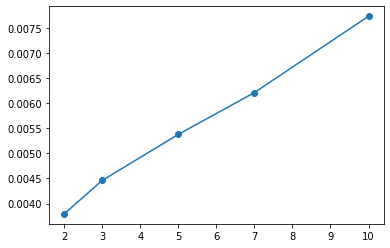

In [13]:
plt.plot(output_time_step,RMSE, marker='o')

In [14]:
MAE

[0.003519443386812868,
 0.0040041392693964065,
 0.0047168383909770425,
 0.005428164752867644,
 0.006765662151116054]

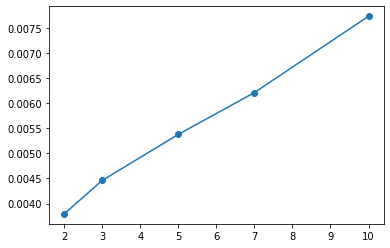

In [15]:
plt.plot(output_time_step,RMSE, marker='o')